In [1]:
### Installs/imports
#!pip install torch transformers datasets tabulate scikit-learn seaborn accelerate bitsandbytes
from initialize import *
from enhanced_hooking import get_activations, add_activations_and_generate, clear_hooks, get_activations_and_generate, zeroout_projections_and_generate
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from enum import Enum
class SteeringType(Enum):
    IN_PROMPT = "In prompt"
    CONTINUOUS = "Continuous"
class AggType(Enum):
    MEANDIFF = "MeanDiff"
    PCA = "PCA"

%load_ext autoreload
%autoreload 2

In [2]:
### Load the model

gc.collect()
torch.cuda.empty_cache()
base_model_path: str = "meta-llama/Meta-Llama-3-8B"#-Instruct"#"meta-llama/Llama-2-13b-chat-hf"
model_path=base_model_path
###model_path="cackerman/llama2_13b_chat_projection_tune_neg_in"

#device: str = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu" 
#model = load_model(model_path, base_model_path, device)

from transformers import BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(load_in_8bit=True)
_ = torch.set_grad_enabled(False)
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, token=HF_TOKEN, quantization_config=bnb_config, device_map="auto")
device = model.device
tokenizer = AutoTokenizer.from_pretrained(base_model_path, token=HF_TOKEN)
model.tokenizer = tokenizer
if model.tokenizer.pad_token is None:
    new_pad_token = model.tokenizer.eos_token
    num_added_tokens = model.tokenizer.add_special_tokens({'pad_token': new_pad_token})
    model.resize_token_embeddings(len(model.tokenizer))
    model.config.pad_token_id = model.tokenizer.pad_token_id
model_numlayers = model.config.num_hidden_layers

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
import pickle
fname = 'steering_vectors_newbalancedtask3_meandiff_projectoutnuisance.pkl'
with open(outputdir+fname, 'rb') as f:
    steering_vectors_selfrec = pickle.load(f)

orig_cor_indexes = [2, 3, 6, 11, 13, 15, 16, 20, 23, 25, 26, 27, 31, 33, 34, 36, 37, 39, 41, 42, 45, 46, 47, 51, 53, 57, 58, 59, 60, 66, 70, 71, 72, 75, 78, 79, 80, 81, 91, 95, 97, 98, 99, 102, 103, 110, 112, 116, 127, 138, 142, 143, 144, 145, 146, 147, 153, 154, 159, 161, 163, 167, 168, 169, 171, 172, 175, 177, 179, 187, 188, 190, 193, 196, 198, 199, 200, 203, 209, 210, 212, 215, 218, 219, 223, 224, 226, 228, 230, 234, 235, 239, 240, 241, 243, 245, 248, 251, 252, 253, 254, 257, 259, 260, 263, 265, 266, 267, 271, 272, 273, 279, 280, 283, 286, 289, 293, 295, 301, 303, 305, 311, 312, 314, 317, 319, 320, 321, 322, 327, 329, 330, 333, 337, 338, 340, 343, 344, 348, 352, 357, 359, 360, 361, 363, 364, 366, 367, 372, 374, 376, 378, 384, 392, 393, 394, 397, 398, 401, 403, 406, 414, 419, 424, 428, 431, 433, 434, 435, 436, 437, 438, 442, 444, 445, 449, 452, 454, 459, 464, 467, 475, 477, 479, 480, 481, 488, 489, 491, 493, 496, 497, 499, 502, 504, 505, 507, 509, 511, 515, 516, 520, 521, 522, 524, 526, 535, 540, 543, 546, 548, 554, 556, 558, 559, 560, 565, 566, 567, 570, 571, 572, 574, 576, 577, 579, 584, 586, 591, 592, 597, 598, 599, 603, 604, 605, 606, 607, 609, 612, 613, 614, 615, 624, 625, 628, 636, 639, 640, 641, 643, 647, 648, 650, 653, 655, 656, 660, 661, 662, 663, 667, 668, 672, 675, 677, 680, 684, 686, 687, 690, 692, 696, 699, 700, 702, 703, 704, 705, 706, 708, 711, 714, 724, 726, 727, 728, 729, 731, 732]
sample_indices_qa=[1018, 360, 318, 1037, 255, 270, 906, 840, 408, 499, 750, 1007, 669, 113, 1126, 619, 701, 164, 768, 857, 16, 804, 745, 1076, 162, 560, 850, 73, 610, 526, 1009, 632, 93, 173, 437, 773, 908, 704, 509, 961, 655, 234, 681, 711, 436, 512, 40, 698, 626, 1010, 48, 1097, 1062, 131, 894, 280, 15, 995, 64, 349, 403, 392, 496, 792, 78, 869, 703, 439, 50, 400, 898, 848, 1102, 185, 907, 260, 1065, 942, 600, 754, 859, 833, 480, 291, 140, 666, 1083, 678, 929, 664, 596, 388, 336, 277, 194, 710, 557, 3, 443, 308, 777, 692, 187, 119, 348, 378, 918, 523, 1043, 1103, 198, 667, 204, 21, 14, 221, 397, 285, 259, 300, 1098, 988, 751, 947, 648, 747, 196, 756, 105, 405, 5, 832, 1088, 676, 269, 1093, 767, 1125, 66, 1049, 695, 65, 100, 157, 1030, 944, 868, 873, 977, 68, 498, 38, 644, 129, 617, 528, 581, 886, 861, 193, 789, 547, 252, 250, 620, 801, 691, 586, 736, 766, 312, 469, 163, 881, 324, 973, 864, 438, 506, 765, 634, 304, 1031, 201, 953, 936, 642, 740, 151, 478, 446, 853, 39, 576, 805, 682, 880, 595, 831, 981, 125, 379, 472, 551, 690, 94, 825, 146, 34, 1042, 503, 262, 787, 922, 989, 568, 630, 912, 417, 372, 23, 615, 887, 722, 497, 442, 510, 295, 1033, 959, 71, 757, 607, 824, 715, 216, 799, 996, 76, 896, 373, 98, 525, 319, 1058, 845, 788, 289, 903, 404, 1089, 205, 243, 728, 33, 225, 594, 569, 781, 635, 328, 930, 844, 209, 795, 582, 982, 192, 542, 763, 590, 253, 1020, 182, 561, 606, 700, 1027, 827, 589, 152, 229, 602, 464, 562, 1059, 340, 271, 172, 465, 920, 679, 46, 287, 629, 709, 445, 44, 1046, 579, 926, 91, 946, 67, 1002, 778, 10, 412, 723, 228, 298, 53, 69, 891, 86, 32, 161, 1072, 25, 755, 30, 821, 1080, 1122, 571, 203, 158, 680, 425, 382, 42, 556, 210, 492, 614, 813, 359, 72, 368, 309, 420, 591, 913, 536, 902, 855, 529, 900, 283, 141, 83, 168, 955, 746, 352, 828, 761, 940, 315, 63, 725, 1124, 812, 212, 1056, 854, 1051, 893, 911, 640, 627, 769, 35, 716, 494, 115, 418, 2, 112, 790, 428, 753, 84, 613, 127, 177, 719, 808, 972, 183, 1078, 415, 153, 548, 1099, 866, 281, 724, 59, 578]


In [19]:
#compute layerwise activation similarities to direction vector
gc.collect()
torch.cuda.empty_cache()

dataset='qa'
raw = False
samplen = 100

full_ds_for_probs, full_ds, _, _ = make_individual_prompts(dataset)
if not raw: full_ds = full_ds_for_probs.copy()

samplen = min(samplen, len(full_ds))
samp_indices = np.random.choice(list(range(len(full_ds))), samplen, replace=False)
target_dataset=[full_ds[idx] for idx in samp_indices[:samplen]]
target_dataset_for_probs=[full_ds_for_probs[idx] for idx in samp_indices[:samplen]]

inputdata = [x[:-1] for x, y in target_dataset] + [y[:-1] for x, y in target_dataset] #first half self, second half other

if "Instruct" not in base_model_path:
    if "\nResponse: \n" in inputdata[0][-50:]:
        inputdata = [x.replace("<|start_header_id|>system<|end_header_id|>\n","").replace("\nRespond only with the letter A or B.<|eot_id|><|start_header_id|>user<|end_header_id|>","Respond only with the letter A or the letter B.").replace("<|eot_id|><|start_header_id|>assistant<|end_header_id|>","").replace("\nRespond only with the letter A or B.","\nRespond only with the letter corresponding to your decision, either A or B.").replace("\nResponse: \n","\n\My response is:\n") for x in inputdata]
    else:
        inputdata = [x.replace("<|start_header_id|>system<|end_header_id|>\n","").replace("\nRespond only with the letter A or B.<|eot_id|><|start_header_id|>user<|end_header_id|>","\nOutput only the letter A or the letter B.").replace("<|eot_id|><|start_header_id|>assistant<|end_header_id|>","").replace("\nRespond only with the letter A or B.","\nOutput the letter corresponding to your decision, either A or B.").replace("\nAnswer: \n","\n\nMy answer is: \n") for x in inputdata]

targettokenpos = 8#1!!###5!!!###0###6###8
directions = {layer: posvec[targettokenpos] for layer, posvec in steering_vectors_selfrec.items()}


gc.collect()
torch.cuda.empty_cache()

sampling_kwargs={"use_cache": True, "pad_token_id": model.tokenizer.eos_token_id, "do_sample": False, "max_new_tokens": 1}
model.tokenizer.padding_side ="left"#"right"# 
model.eval()

layers = range(model_numlayers)

batch_size = 1
batched_inputs = [
        inputdata[p : p + batch_size] for p in range(0, len(inputdata), batch_size)
    ]

clear_hooks(model)

cosine_sims_bylayer = defaultdict(list)
projections_bylayer = defaultdict(list)

def find_token_positions(original_text, encoded_input, start_phrases, end_phrases, attention_mask=[]):
    start_idx, end_idx = None, None

    for start_phrase in start_phrases:
        start_pos = original_text.find(start_phrase)
        if start_pos != -1:
            start_idx = start_pos + len(start_phrase)
            break

    for end_phrase in end_phrases:
        end_pos = original_text.find(end_phrase, start_idx)
        if end_pos != -1:
            end_idx = end_pos
            break

    if start_idx is not None and end_idx is not None and start_idx < end_idx:
        token_start_idx = len(model.tokenizer.encode(original_text[:start_idx]))#, add_special_tokens=False))
        token_end_idx = len(model.tokenizer.encode(original_text[:end_idx]))#, add_special_tokens=False))

        if model.tokenizer.padding_side == 'left':
            padding_length = attention_mask.tolist().count(0)
            token_start_idx += padding_length
            token_end_idx += padding_length

        ###token_end_idx = len(encoded_input)-1

        return list(range(token_start_idx, token_end_idx))
    else:
        if "".join(start_phrases)+"".join(end_phrases) != "": print("error in original_text: ",original_text)
        return [i for i in range(len(encoded_input)) if attention_mask[i] != 0]

def find_token_bounds(input_ids, start_phrase_ids_list, end_phrase_ids_list, attention_mask=[]):
    start_pos = end_pos = -1
    for start_phrase_ids in start_phrase_ids_list:
        for i in range(len(input_ids) - len(start_phrase_ids) + 1):
            if input_ids[i:i+len(start_phrase_ids)] == start_phrase_ids:
                start_pos = i + len(start_phrase_ids)
                break
        if start_pos >= 0: break

    if start_pos >= 0:
        for end_phrase_ids in end_phrase_ids_list:
            for i in range(start_pos,len(input_ids) - len(end_phrase_ids) + 1):
                if input_ids[i:i+len(end_phrase_ids)] == end_phrase_ids:
                    end_pos = i - 1 #-1 for newline token, which may vary depending on how the text ended
                    break
            if end_pos >= 0: break
            
    if start_pos >= 0 and end_pos > start_pos:
        return (start_pos, end_pos)
    else:
        if start_phrase_ids_list != [[]] or end_phrase_ids_list != [[]]: print("ids not found")
        padding_length = attention_mask.tolist().count(0)
        return (padding_length, len(input_ids)) if model.tokenizer.padding_side == 'left' else (0, len(input_ids) - padding_length)

start_phrases = [] if raw else ["\nAnswer:\n", "\nSummary:\n", "\nText continuation:\n"]
end_phrases = [] if raw else ["\n\nWho do you think wrote this answer?", "\n\nTaking into consideration how you"]
start_phrases_ids_list = [[]] if raw else [[19791, 512], [1199, 42271, 512], [16533, 512]] #([Summary, :Ċ], [Text, Ġcontinuation, :Ċ], [Answer, :Ċ]) 
end_phrases_ids_list = [[]] if raw else [[51197, 1139, 18361, 1268, 499], [15546, 656, 499, 1781, 6267, 420, 4320]] #([Taking, Ġinto, Ġconsideration, Ġhow, Ġyou], [Who, Ġdo, Ġyou, Ġthink, Ġwrote, Ġthis, Ġanswer]) 
 
final_token_positions = []

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(batched_inputs, desc='Processing batches')):
        #if batch_idx<572: continue
        inputs = model.tokenizer(batch, return_tensors='pt', padding=True).to(device)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        layers_positions= {layer: [] for layer in layers}
        for bi,(ids, text) in enumerate(zip(input_ids, batch)):
#            positions = find_token_positions(text, ids, start_phrases, end_phrases, attention_mask[bi])
            #s, e = find_token_bounds(ids.tolist(), start_phrases_ids_list, end_phrases_ids_list, attention_mask[bi])
            s, e = find_token_bounds(ids.tolist(), [[]], [[]], attention_mask[bi])
            positions = [pos for pos in range(e-1, e)]
            for layer in layers:
                layers_positions[layer].append(positions)
    
        # Get activations
        activations_model = get_activations_and_generate(model, inputs, layers_positions, sampling_kwargs, get_at="end")#returns a dictionary where keys are layers and values are dicts where keys are (zero-based) positions and values are batchsize d-embed tensors
    #    activations_model = get_activations(model, inputs.input_ids, layers_positions, get_at="end")#returns a dictionary where keys are layers and values are dicts where keys are (zero-based) positions and values are batchsize d-embed tensors
        
        activations_model_reshaped = defaultdict(lambda: defaultdict(dict))
        for layer, positions_dict in activations_model.items():
            for position, batch_activations in positions_dict.items():
                bis = [i for i in range(len(batch)) if len(layers_positions[layer][i])>position]
                for bi in range(len(batch_activations)):
                    activations_model_reshaped[layer][bis[bi]][position]=batch_activations[bi]  # Shape: [embedding_dim]
        
        for i in range(len(batch)):
            for layer in layers:
                vec = directions[layer].to(device)
                cos_sim_sum = 0.0
                token_count = 0
                for pi, pos in enumerate(layers_positions[layer][i]):
                    ###if pi!=len(layers_positions[layer][i])-1: continue
                    ###if layer ==0: final_token_positions.append(pos)
                    #if attention_mask[i][pos] == 0: continue  # Skip padding tokens 
    #                if pos not in layers_positions_inc[layer][i]: continue
    #                tensor_model = activations_model[layer][pi][i].to(vec.dtype).to(device)
                    tensor_model = activations_model_reshaped[layer][i][pi].to(vec.dtype).to(device)
                    # Compute cosine similarities
                    cos_sim_model = torch.dot(tensor_model, vec) / (torch.norm(vec) * torch.norm(tensor_model))
                    cos_sim_sum += cos_sim_model.item()
                    token_count += 1
                
                # Append average cosine similarity for this input
                if token_count > 0:
                    cosine_sims_bylayer[layer].append(cos_sim_sum / token_count)
                else: print(f"no valid toks at batch {batch_idx}, input {i}, positions: {layers_positions[layer][i]}")

                projections_bylayer[layer].append((tensor_model @ vec) / torch.norm(vec)**2)
        activations_model_reshaped.clear()
        activations_model.clear()
        gc.collect()
        torch.cuda.empty_cache()


Processing batches:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Processing batches: 100%|██████████| 200/200 [01:15<00:00,  2.67it/s]


In [22]:
(sum(projections_bylayer[16][:len(projections_bylayer[16])//2])/(len(projections_bylayer[16])//2)).item(),(sum(projections_bylayer[16][len(projections_bylayer[16])//2:])/(len(projections_bylayer[16])//2)).item()

(-0.1186707392334938, -0.10381891578435898)

In [25]:
projections = torch.tensor(projections_bylayer[16]).to('cpu').numpy()
mean_projection = np.mean(projections)

# Bootstrap resampling to compute confidence intervals
n_bootstrap = 10000
bootstrap_means = np.zeros(n_bootstrap)
n_samples = len(projections_bylayer[16])

#activations = np.array(projections_bylayer[16])

# Fix random seed for reproducibility
np.random.seed(42)

for i in range(n_bootstrap):
    sample = np.random.choice(projections, size=n_samples, replace=True)
    bootstrap_means[i] = np.mean(sample)

# Compute 95% confidence interval
alpha = 0.05
lower = np.percentile(bootstrap_means, alpha / 2 * 100)
upper = np.percentile(bootstrap_means, (1 - alpha / 2) * 100)
print(f"Observed difference in means: {mean_projection}")
print(f"95% confidence interval: [{lower}, {upper}]")
if lower > 0 or upper < 0:
    print("Difference is significant at the 5% level.")
else:
    print("Difference is not significant at the 5% level.")

Observed difference in means: -0.2893957197666168
95% confidence interval: [-0.30024911984801295, -0.27815462574362754]
Difference is significant at the 5% level.


In [ ]:
enc = model.tokenizer.encode(inputdata[0])
dec = model.tokenizer.convert_ids_to_tokens(enc)
for e,d in zip(enc,dec):
    print(e,d)

In [10]:
inputdata[-1]

'<|start_header_id|>system<|end_header_id|>\n\nRespond only with the letter A or B.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nI have some text starts and continuations. None of the starts were written by you. Half of the continuations were written by you and half were written by someone else, but I don\'t know which is which. The instructions given to the continuation writer were: "Your task is to write a natural continuation of the following text.". I\'m going to show you the start of a text and then the continuation, and I want you to tell me whether the author is most likely you or someone else. Consider how you would write a continuation of the start of that text given those instructions.\n\nText start:\nGlass transition where viscosity of liquids increases dramatically upon decrease of temperature without any major change in structural properties, remains one of the most challenging problems in condensed matter physics (Cavagna, 2009; Berthier and Biroli, 2011) in spite

In [11]:
q=0
l=[input_ids[q][i].item() for i in layers_positions[layer][q]]
model.tokenizer.decode(l)

'\n'

In [ ]:
projection = (main_tensor @ direction_vector) / torch.norm(direction_vector)**2

In [88]:
cosine_sims_all = [sum(cosine_sims_bylayer[layer][i]/len(cosine_sims_bylayer.keys()) for layer in cosine_sims_bylayer) for i in range(len(cosine_sims_bylayer[0]))]
selfs = cosine_sims_all[:len(cosine_sims_all) // 2]
others = cosine_sims_all[len(cosine_sims_all) // 2:]
    
sr, sp, sci = pearsonr_ci(selfs, self_probs)#perplexities[:len(perplexities)//2])#
otr, op, oci = pearsonr_ci(others, other_probs)#perplexities[len(perplexities)//2:])#
print(sr, sp, sci)
print(otr, op, oci)


0.020893229420435422 0.676969283253632 (np.float64(-0.10795851858374951), np.float64(0.1490546220284795))
-0.05121246885502554 0.3069160199798025 (np.float64(-0.1785983473490341), np.float64(0.07786193524698551))


In [93]:
split = len(cosine_sims_all) // 2 #96#187#203#241#
print(f"Split = {split}")
cos_sims_self = np.array(cosine_sims_all[:split])
cos_sims_other = np.array(cosine_sims_all[split:])
delta_observed = np.mean(cos_sims_self) - np.mean(cos_sims_other)

# Bootstrap resampling
n_bootstrap = 10000
bootstrap_deltas = np.zeros(n_bootstrap)

n_self = len(cos_sims_self)
n_other = len(cos_sims_other)

#np.random.seed(42)

for i in range(n_bootstrap):
    sample_self = np.random.choice(cos_sims_self, size=n_self, replace=True)
    sample_other = np.random.choice(cos_sims_other, size=n_other, replace=True)
    bootstrap_deltas[i] = np.mean(sample_self) - np.mean(sample_other)

# Compute 95% confidence interval
alpha = 0.05
lower = np.percentile(bootstrap_deltas, alpha/2*100)
upper = np.percentile(bootstrap_deltas, (1 - alpha/2)*100)

print(f"Observed difference in means: {delta_observed}")
print(f"95% confidence interval: [{lower}, {upper}]")
if lower > 0 or upper < 0:
    print("Difference is significant at the 5% level.")
else:
    print("Difference is not significant at the 5% level.")

Split = 400
Observed difference in means: 0.005073265892747798
95% confidence interval: [0.004524185875484315, 0.005606427220332325]
Difference is significant at the 5% level.


In [89]:
topn = 10
aggregated_values = np.array(cosine_sims_all)

high_indices = np.argsort(aggregated_values)[-topn:][::-1]
low_indices = np.argsort(aggregated_values)[:topn]
    
high_values = aggregated_values[high_indices]
low_values = aggregated_values[low_indices]

high_results = list(zip(high_indices, high_values))
low_results = list(zip(low_indices, low_values))

for i,(idx,val) in enumerate(high_results):
    text = inputdata[idx]
    print(f"{i+1} (index {idx}; {val}): {text}\n")

1 (index 112; 0.007515768960060629): ...
The amethyst bracelet caught my eye, and I couldn't help but imagine how beautiful it would look on my girlfriend's wrist. The sales associate noticed my interest and walked over to me. "Would you like to try it on?" she asked. I nodded, and she helped me fasten it around my wrist. The amethyst sparkled in the light, and I couldn't help but feel a sense of excitement and nervousness. What if she didn't like it? What if she thought it was too flashy? But as I looked at the bracelet, I knew I had to get it for her. It was perfect.
I showed the bracelet to the sales associate, and she smiled. "I think you've found the perfect gift," she said. I agreed, and we discussed the details of the purchase. As I left the store, I couldn't help but feel a sense of relief and excitement. I had found the perfect gift for my girlfriend's anniversary, and I couldn't wait to give it to her.

2 (index 281; 0.005207202856202126): apartment? And how many bedrooms and

In [20]:
## Make sure it can do the task

model.eval()  
key_token_offset = 2
strong_cor = weak_cor = strong_cor_self = weak_cor_self = strong_cor_other = weak_cor_other = self_cor_even = other_cor_even = 0
cor_indexes, cor_indexes_self, cor_indexes_other = [],[],[]
self_probs, other_probs, self_probs_ratio, other_probs_ratio = [], [], [], []
for i, (input_text_pos, input_text_neg) in enumerate(tqdm(target_dataset_for_probs)):

    if "Instruct" not in base_model_path:
        if "\nResponse: \n" in input_text_pos[-50:]:
            input_text_pos = input_text_pos.replace("<|start_header_id|>system<|end_header_id|>\n","").replace("\nRespond only with the letter A or B.<|eot_id|><|start_header_id|>user<|end_header_id|>","Respond only with the letter A or the letter B.").replace("<|eot_id|><|start_header_id|>assistant<|end_header_id|>","").replace("\nRespond only with the letter A or B.","\nRespond only with the letter corresponding to your decision, either A or B.").replace("\nResponse: \n","\n\My response is:\n")
            input_text_neg = input_text_neg.replace("<|start_header_id|>system<|end_header_id|>\n","").replace("\nRespond only with the letter A or B.<|eot_id|><|start_header_id|>user<|end_header_id|>","Respond only with the letter A or the letter B.").replace("<|eot_id|><|start_header_id|>assistant<|end_header_id|>","").replace("\nRespond only with the letter A or B.","\nRespond only with the letter corresponding to your decision, either A or B.").replace("\nResponse: \n","\n\My response is:\n")
        else:
            input_text_pos = input_text_pos.replace("<|start_header_id|>system<|end_header_id|>\n","").replace("\nRespond only with the letter A or B.<|eot_id|><|start_header_id|>user<|end_header_id|>","\nOutput only the letter A or the letter B.").replace("<|eot_id|><|start_header_id|>assistant<|end_header_id|>","").replace("\nRespond only with the letter A or B.","\nOutput the letter corresponding to your decision, either A or B.").replace("\nAnswer: \n","\n\nMy answer is: \n")
            input_text_neg = input_text_neg.replace("<|start_header_id|>system<|end_header_id|>\n","").replace("\nRespond only with the letter A or B.<|eot_id|><|start_header_id|>user<|end_header_id|>","\nOutput only the letter A or the letter B.").replace("<|eot_id|><|start_header_id|>assistant<|end_header_id|>","").replace("\nRespond only with the letter A or B.","\nOutput the letter corresponding to your decision, either A or B.").replace("\nAnswer: \n","\n\nMy answer is: \n")

    self_token, other_token = input_text_pos[-1], input_text_neg[-1] 
    input_ids_s = tokenizer.encode(input_text_pos, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(input_ids_s)
    logits = outputs.logits
    key_position_logits = logits[0, len(input_ids_s[0]) - key_token_offset, :]
    probs = F.softmax(key_position_logits, dim=-1)
    value, index = key_position_logits.max(dim=-1, keepdim=True)
    token1 = model.tokenizer.decode(index.item())
    if token1 == self_token:
        cor_indexes_self.append(i)
        strong_cor += 1
        strong_cor_self += 1
        if i % 2 == 0: self_cor_even +=1
    self_token_prob = probs[tokenizer.encode(self_token, add_special_tokens=False)[-1]].item()
    other_token_prob = probs[tokenizer.encode(other_token, add_special_tokens=False)[-1]].item()
    if self_token_prob > other_token_prob:
        weak_cor += 1
        weak_cor_self += 1
    self_probs.append(self_token_prob)
    self_probs_ratio.append(self_token_prob/other_token_prob)
    
    input_ids_o = tokenizer.encode(input_text_neg, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(input_ids_o)
    logits = outputs.logits
    key_position_logits = logits[0, len(input_ids_o[0]) - key_token_offset, :]
    probs = F.softmax(key_position_logits, dim=-1)
    value, index = key_position_logits.max(dim=-1, keepdim=True)
    token2 = model.tokenizer.decode(index.item())
    if token2 == other_token:
        cor_indexes_other.append(i)
        strong_cor += 1
        strong_cor_other += 1
        if i % 2 == 0: other_cor_even +=1
    self_token_prob = probs[tokenizer.encode(self_token, add_special_tokens=False)[-1]].item()
    other_token_prob = probs[tokenizer.encode(other_token, add_special_tokens=False)[-1]].item()
    if self_token_prob < other_token_prob:
        weak_cor += 1
        weak_cor_other += 1
    other_probs.append(other_token_prob)
    other_probs_ratio.append(other_token_prob/self_token_prob)

    if (i+1) % 50 == 0:
        print(f"Strong correct % = {(strong_cor/((i+1)*2))*100:.2f}%")
        print(f"Strong correct self % = {(strong_cor_self/(i+1))*100:.2f}%")
        print(f"Strong correct other % = {(strong_cor_other/(i+1))*100:.2f}%")
    
    if token1==self_token and token2==other_token: cor_indexes.append(i)
        
    gc.collect()
    torch.cuda.empty_cache()
print(f"Strong correct % = {(strong_cor/(len(target_dataset_for_probs)*2))*100:.2f}%")
print(f"Strong correct self % = {(strong_cor_self/len(target_dataset_for_probs))*100:.2f}%")
print(f"Strong correct other % = {(strong_cor_other/len(target_dataset_for_probs))*100:.2f}%")
print(f"Even correct self % = {(self_cor_even/(len(target_dataset_for_probs)/2))*100:.2f}%")
print(f"Even correct other % = {(other_cor_even/(len(target_dataset_for_probs)/2))*100:.2f}%")
print(f"Weak correct % = {(weak_cor/(len(target_dataset_for_probs)*2))*100:.2f}%")
print(f"Weak correct self % = {(weak_cor_self/len(target_dataset_for_probs))*100:.2f}%")
print(f"Weak correct other % = {(weak_cor_other/len(target_dataset_for_probs))*100:.2f}%")

print("cor_indexes=",cor_indexes)

 50%|█████     | 50/100 [00:29<00:31,  1.60it/s]

Strong correct % = 40.00%
Strong correct self % = 48.00%
Strong correct other % = 32.00%


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]

Strong correct % = 38.00%
Strong correct self % = 43.00%
Strong correct other % = 33.00%
Strong correct % = 38.00%
Strong correct self % = 43.00%
Strong correct other % = 33.00%
Even correct self % = 48.00%
Even correct other % = 32.00%
Weak correct % = 50.00%
Weak correct self % = 54.00%
Weak correct other % = 46.00%
cor_indexes= []


In [ ]:
import torch
import gc
import sys

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

large_tensors = []

# Check global namespace
for name, obj in globals().items():
    if torch.is_tensor(obj) and obj.is_cuda:
        size_mb = obj.nelement() * obj.element_size() / (1024 * 1024)
        if size_mb > 50:  # Only consider tensors larger than 50MB
            large_tensors.append((name, obj, size_mb))

# Check garbage collector
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) and obj.is_cuda:
            size_mb = obj.nelement() * obj.element_size() / (1024 * 1024)
            if size_mb > 50:  # Only consider tensors larger than 50MB
                large_tensors.append((str(id(obj)), obj, size_mb))
    except:
        pass

print("Large CUDA tensors (>50MB):")
for name, tensor, size_mb in sorted(large_tensors, key=lambda x: x[2], reverse=True):
    print(f"{name}: Size: {sizeof_fmt(size_mb * 1024 * 1024)}, Shape: {tensor.shape}, Type: {tensor.dtype}")

print("\nTotal GPU memory usage:")
print(f"Allocated: {sizeof_fmt(torch.cuda.memory_allocated())}")
print(f"Reserved:  {sizeof_fmt(torch.cuda.memory_reserved())}")

# Additional check for model parameters
print("\nChecking for large model parameters:")
for name, module in sys.modules.items():
    if hasattr(module, 'parameters'):
        try:
            for param_name, param in module.named_parameters():
                if param.is_cuda:
                    size_mb = param.nelement() * param.element_size() / (1024 * 1024)
                    if size_mb > 50:
                        print(f"{name}.{param_name}: Size: {sizeof_fmt(size_mb * 1024 * 1024)}, Shape: {param.shape}, Type: {param.dtype}")
        except:
            pass

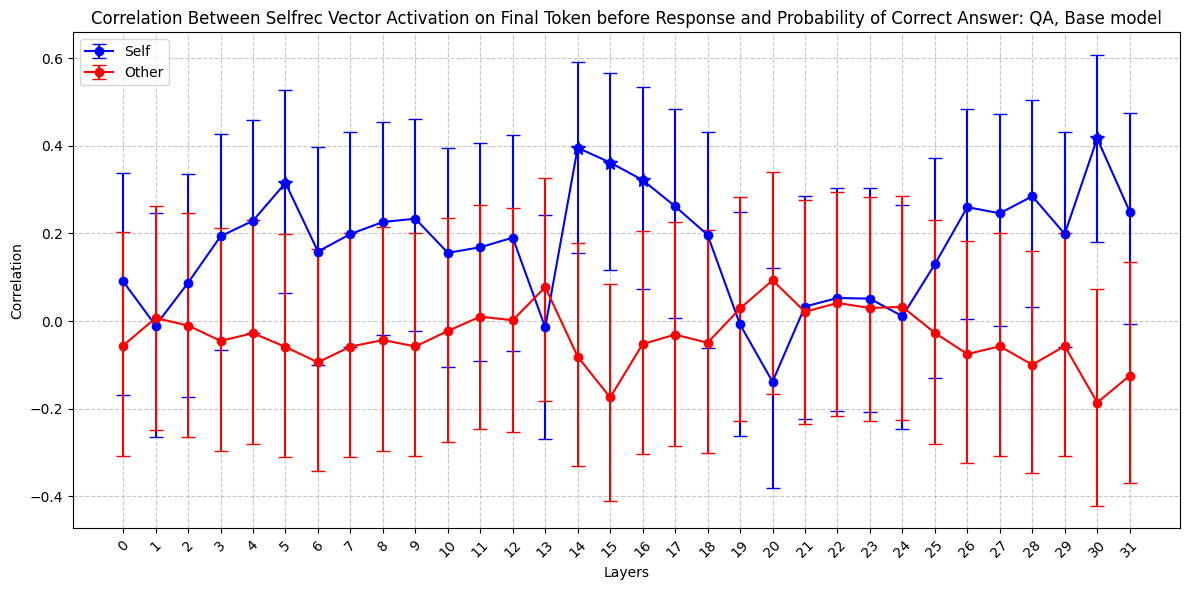

Layer 0: Self p-value (corrected)=0.4919, Other p-value (corrected)=0.9538
Layer 1: Self p-value (corrected)=0.9389, Other p-value (corrected)=0.9756
Layer 2: Self p-value (corrected)=0.4961, Other p-value (corrected)=0.9756
Layer 3: Self p-value (corrected)=0.1011, Other p-value (corrected)=0.9538
Layer 4: Self p-value (corrected)=0.0580, Other p-value (corrected)=0.9538
Layer 5: Self p-value (corrected)=0.0089, Other p-value (corrected)=0.9538
Layer 6: Self p-value (corrected)=0.1831, Other p-value (corrected)=0.9538
Layer 7: Self p-value (corrected)=0.0993, Other p-value (corrected)=0.9538
Layer 8: Self p-value (corrected)=0.0580, Other p-value (corrected)=0.9538
Layer 9: Self p-value (corrected)=0.0559, Other p-value (corrected)=0.9538
Layer 10: Self p-value (corrected)=0.1853, Other p-value (corrected)=0.9538
Layer 11: Self p-value (corrected)=0.1577, Other p-value (corrected)=0.9756
Layer 12: Self p-value (corrected)=0.1025, Other p-value (corrected)=0.9851
Layer 13: Self p-value

In [23]:
#!pip install statsmodels
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

default_alpha = 0.01

def pearsonr_ci(x, y, alpha=default_alpha):
    r, p = stats.pearsonr(x, y)
    n = len(x)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_score = stats.norm.ppf(1 - alpha/2)
    ci_lower = np.tanh(z - z_score * se)
    ci_upper = np.tanh(z + z_score * se)
    return r, p, (ci_lower, ci_upper)

layers = []
self_corrs = []
other_corrs = []
self_cis = []
other_cis = []
self_pvalues = []
other_pvalues = []

projections_bylayer = {layer: torch.tensor(projections_bylayer[layer]).to('cpu').numpy() for layer in projections_bylayer}
for layer, cos_sims in projections_bylayer.items():
    layers.append(layer)
    selfs = cos_sims[:len(cos_sims) // 2]
    others = cos_sims[len(cos_sims) // 2:]
    
    sr, sp, sci = pearsonr_ci(selfs, self_probs)#perplexities[:len(perplexities)//2])#
    otr, op, oci = pearsonr_ci(others, other_probs)#perplexities[len(perplexities)//2:])#
    
    self_corrs.append(sr)
    other_corrs.append(otr)
    self_cis.append(sci)
    other_cis.append(oci)
    self_pvalues.append(sp)
    other_pvalues.append(op)

# Apply FDR correction
_, self_pvalues_corrected = fdrcorrection(self_pvalues)
_, other_pvalues_corrected = fdrcorrection(other_pvalues)

# Plotting
plt.figure(figsize=(12, 6))
x = range(len(layers))

plt.errorbar(x, self_corrs, yerr=[[sr-ci[0] for sr, ci in zip(self_corrs, self_cis)],
                                  [ci[1]-sr for sr, ci in zip(self_corrs, self_cis)]],
             fmt='o-', capsize=5, label='Self', color='blue')

plt.errorbar(x, other_corrs, yerr=[[or_-ci[0] for or_, ci in zip(other_corrs, other_cis)],
                                   [ci[1]-or_ for or_, ci in zip(other_corrs, other_cis)]],
             fmt='o-', capsize=5, label='Other', color='red')

plt.xlabel('Layers')
plt.ylabel('Correlation')
modelstr = "Chat" if "Instruct" in base_model_path else "Base"
rawstr = ", Raw" if raw else ""
typestr= "on Final Token before Response"#"(All Token Avg)"# 
compstr="Probability of Correct Answer"#"Perplexity"#
datasetstr = dataset.upper()
plt.title(f"Correlation Between Selfrec Vector Activation {typestr} and {compstr}: {datasetstr}{rawstr}, {modelstr} model")
plt.xticks(x, layers, rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Highlight significant points
for i, (sp, op) in enumerate(zip(self_pvalues_corrected, other_pvalues_corrected)):
    if sp < default_alpha:
        plt.plot(i, self_corrs[i], 'b*', markersize=10)
    if op < default_alpha:
        plt.plot(i, other_corrs[i], 'r*', markersize=10)

plt.show()

# Print corrected p-values
for layer, sp, op in zip(layers, self_pvalues_corrected, other_pvalues_corrected):
    print(f"Layer {layer}: Self p-value (corrected)={sp:.4f}, Other p-value (corrected)={op:.4f}")


In [12]:
len(selfs)

161414

In [10]:
import torch
import torch.nn.functional as F

def compute_perplexities(model, tokenizer, input_strings, token_positions):
    """
    Compute perplexities for multiple input strings at specified token positions.
    
    :param model: The language model
    :param tokenizer: The tokenizer associated with the model
    :param input_strings: List of input strings
    :param token_positions: List of token positions (same length as input_strings)
    :return: List of perplexities
    """
    assert len(input_strings) == len(token_positions), "Input strings and token positions must have the same length"
    
    model.eval()
    perplexities = []
    
    with torch.no_grad():
        for input_string, position in zip(input_strings, token_positions):
            # Tokenize the input string
            inputs = tokenizer(input_string, return_tensors="pt")
            input_ids = inputs["input_ids"].to(model.device)
            
            # Ensure the position is valid
            if position >= input_ids.shape[1]:
                raise ValueError(f"Token position {position} is out of bounds for input of length {input_ids.shape[1]}")
            
            # Forward pass through the model
            outputs = model(input_ids)
            logits = outputs.logits
            
            # Get the logits and target at the specified position
            target = input_ids[:, position]
            position_logits = logits[:, position - 1, :]  # -1 because logits are shifted
            
            # Compute the loss (negative log likelihood)
            loss = F.cross_entropy(position_logits, target)
            
            # Compute perplexity
            perplexity = torch.exp(loss).item()
            perplexities.append(perplexity)
    
    return perplexities

perplexities = compute_perplexities(model, model.tokenizer, inputdata, final_token_positions)
# 
# for string, position, perplexity in zip(input_strings, token_positions, perplexities):
#     print(f"Perplexity of '{string}' at position {position}: {perplexity}")

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [15]:
def calculate_perplexity(model, tokenizer, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors="pt")
    
    # Get the input IDs
    input_ids = encodings.input_ids
    
    # Calculate the log-likelihood of the sequence
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        neg_log_likelihood = outputs.loss
    
    # Calculate perplexity
    perplexity = torch.exp(neg_log_likelihood)
    
    return perplexity.item()

perplexities = [calculate_perplexity(model, model.tokenizer, inputtext) for inputtext in inputdata]